In [1]:
!pip install swtloc

In [2]:
import glob
import csv
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import threading
import shutil
import pandas as pd
import os
import math
import csv
import cv2
import time
import shutil
import os
import numpy as np
import scipy.optimize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D,concatenate,Conv2D,BatchNormalization,Activation,Lambda
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.applications import VGG16,VGG19
from tqdm import tqdm
import multiprocessing
import scipy.io as sio
from swtloc import SWTLocalizer
from swtloc.utils import imgshowN, imgshow
try:
    import queue
except ImportError:
    import Queue as queue


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training on Synthtext data

Data: https://www.robots.ox.ac.uk/~vgg/data/scenetext/

In [ ]:
#Unzipping our synthtext data
!unzip  "/content/drive/MyDrive/SynthText.zip" 

In [ ]:
print(len(os.listdir('SynthText')))

203


In [ ]:
#Creating directory to store the images path
os.mkdir('synthtext')
#Creating the directory to store annotations
os.makedirs('synth/annotation')

In [ ]:
dataset = sio.loadmat('SynthText/gt.mat')
img_paths = [i[0] for i in dataset['imnames'][0, :]]

In [ ]:
#Storing the path of images into synthtext directory
with open('synthtext/path_to_imgs.txt', 'w') as f:
    for item in img_paths:
        f.write("SynthText/"+"%s\n" % item)

#append words
dataset_word_list = []
for img_words in dataset['txt'][0, :]:
    img_word_list = []
    for words in img_words:
        for word in [item for sublist in [i.strip().split(' ') for i in words.split('\n')] for item in sublist]:
            if word != '':
                img_word_list.append(word)
    dataset_word_list.append(img_word_list)

#polys and words
iter = 0
for polys, words, img_path in tqdm(zip(dataset['wordBB'][0, :], dataset_word_list, img_paths)):

    # fix poly
    if len(polys.shape) == 2:
        polys = polys[:, :, np.newaxis]
    polys = polys.transpose([-1, 0, 1])

    # check if all match up
    if polys.shape[0] != len(words):
        print('number of polys and words do not mathc')
        break

    #Storing the annotations in the synth/annotation directory
    with open('synth/annotation/{}.txt'.format(img_path.split('/')[1].split('.')[0]), 'w') as f:
        for poly, word in zip(polys, words):
            line = np.around(poly, 1).ravel()
            line = np.concatenate([line, [word]], axis=0)
            for item in line:
                f.write("%s " % item)
            f.write("\n")
    iter += 1

858750it [06:33, 2184.26it/s]


In [ ]:
files=os.listdir('synth/annotation')
CLASSES=[]
for i in tqdm(files):
    file=open('synth/annotation/'+i,'r')
    for line in file:
        #Replacing the '\n' with ''
        line=line.replace('\n','')
        #Splitting the line and taking all words
        a=line.split(",")[-1]
        if a!='':
            #Appending the words
            CLASSES.append(a)
NUM_CLASSES=len(list(set(CLASSES)))

100%|██████████| 858750/858750 [01:09<00:00, 12284.95it/s]


In [ ]:
print(NUM_CLASSES)

7029710


### Methods for Text Detection before the Deep learning Era:

#### a.MSER:
MSER stands for Maximally stable Extremel Regions.It is a method for detecting the points in images with different properties like brightness or color compared to the surroundings.



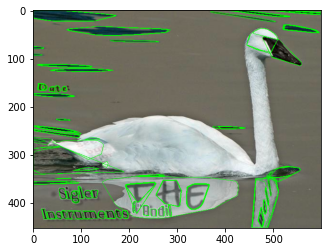

In [ ]:
#https://stackoverflow.com/questions/40078625/opencv-mser-detect-text-areas-python
mser = cv2.MSER_create()
img = cv2.imread('SynthText/172/swan_2_0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
regions, _ = mser.detectRegions(gray)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(img, hulls, 1, (0, 255, 0))
plt.grid(False)
plt.imshow(img)

#### b.SWT(Stroke Width Transform):
SWT stands for Stroke Width Transform.It detects text segments in an image of a natural scene,It receives an RGB image and return a new image of the same size,where the regions suspected text are marked.


MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



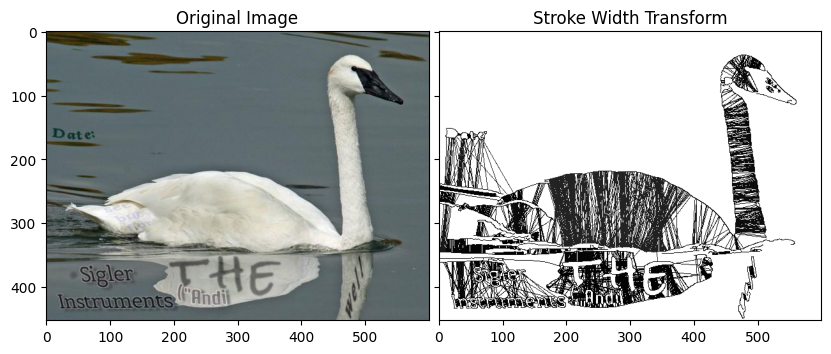

In [ ]:
#https://stackoverflow.com/questions/11116199/stroke-width-transform-swt-implementation-python
swtl = SWTLocalizer()
imgpaths = ... # Image paths, can be one image or more than one
swtl.swttransform(imgpaths='SynthText/172/swan_2_0.jpg', save_results=True, save_rootpath='swtres/',edge_func = 'ac', 
                  ac_sigma = 1.0, text_mode = 'db_lf',gs_blurr=True, blurr_kernel = (5,5), minrsw = 3,maxCC_comppx = 10000, maxrsw = 200, max_angledev = np.pi/6, 
                  acceptCC_aspectratio = 0.5)
imgshowN([swtl.orig_img, swtl.swt_mat], ['Original Image', 'Stroke Width Transform'])

### Methods in the Deep Learning Era

### TEXT DETECTION

#### EAST:

1) EAST stands for Efficient and Accurate Scene Text Detector.EAST algorithm uses a single neural network to predict a word or line-level text.It can detect text in arbitery orientation with quadrilateral shapes.In the year 2017 this algorithm is the state of the art algorithm.This algorithm consists a Fully Convolutional network with a non max suppression merging state.The fully convolutional network is used to localize the text in the image and NMS stage is basically used to merge many imprecise detected text boxes into a single bounding box for every text region.

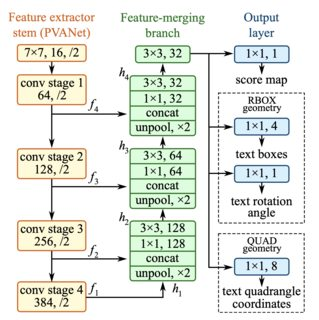

In [ ]:
from IPython.display import Image
Image(filename='pvanet.jpg',width=400)

#### 1.Feature Extractor stem:
    This branch is used to extract the features from different layers of the network.There are 4 convolutional stages in the PVAnet.Each convolutional stage has pooled layer.from this network four feature maps are generated these feature maps are denoted as f1,f2,f3,f4 from above diagram.These f1,f2,f3,f4 are send into the Feature merging branch.

#### 2. Feature Merging Stem:
In this branch the output of F1 is feed into the unpool layer which double its size,then concatenated with currentfeature map then feed into convolutional layer with 1*1 and 128 filters then again convolutional layer will applied with 3*3 and 128 filters.


#### 3.Output layer: 
The final output from feature-merging branch is sent into the scoremap,RBOX geometry and QUAD Geometry

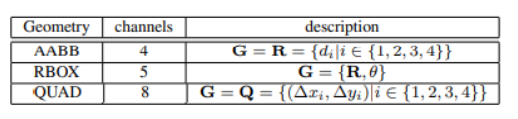

In [ ]:
from IPython.display import Image
Image(filename='output layer.png',width=500)

#### 3.1 Scoremap: 
    The final output from feature-merging branch is passed to the 1*1convolutional layer with 1 filter the generates the score map.score map range is in between 0to1.

#### 3.2 RBOX Geometry:
    This Geometry uses a four channel axis-aligned bouding box(AABB) and a channel rotation angle theta.The 4 channels represents a 4 distances and 1 channel represents a rotation angle theta.

#### 3.3 QUAD Geometry:
    For QUAD Geometry we uses 8 channels.


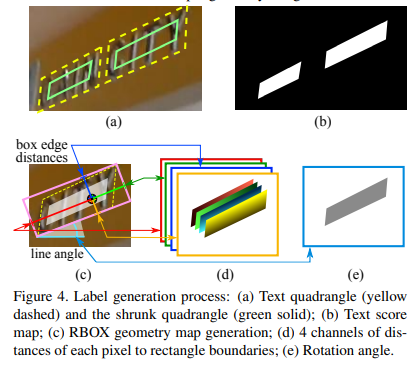

In [ ]:
from IPython.display import Image
Image(filename='all.PNG',width=400)

#### Loss Functions:

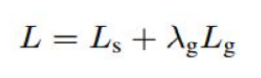

In [ ]:
from IPython.display import Image
Image(filename='loss.PNG',width=200)

Where "Ls" represents the Scoremap loss,"Lg" represents the Geometry loss,"lambda(g)" represents the  weights the importance between two losses. 

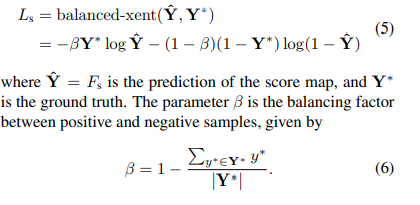

In [ ]:
from IPython.display import Image
Image(filename='scoremap_loss.PNG',width=400)

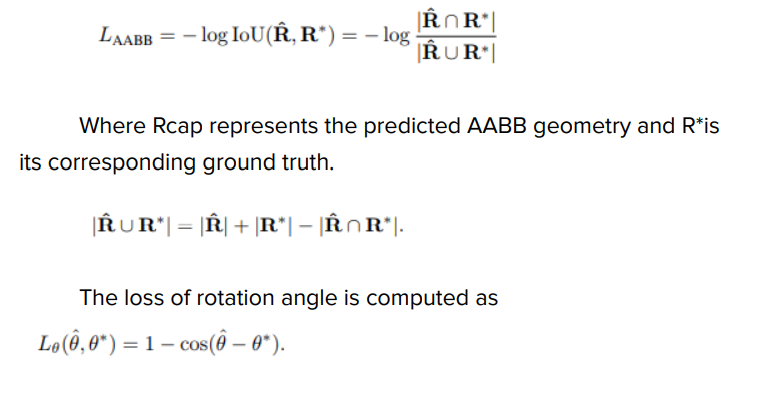

In [ ]:
from IPython.display import Image
Image(filename='rbox.PNG',width=400)

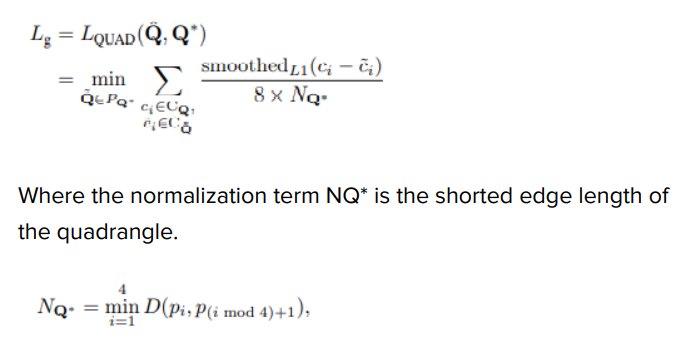

In [ ]:
from IPython.display import Image
Image(filename='quad.PNG',width=400)

#### Load annotation for synthtext

In [ ]:
#https://github.com/argman/EAST/blob/master/icdar.py
def load_annotation(p):
    '''
    load polygon coordinate and text from the text file for corresponding image
    here p is name of image file whose cooresponding annotation we want 
    '''
    text_polys = []
    text_tags = []
    labels = []
    
    p=p.split('/')[-1]
    p=p.replace('jpg','txt')
    p=p.replace('png','txt')
    p=p.replace('jpeg','txt')
    p='synth/annotation/'+p
    
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32)
    with open(p, 'r', encoding='utf-8-sig') as f:
        for line in f.readlines():
            # strip BOM. \ufeff for python3,  \xef\xbb\bf for python2
            # line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]
            line = line.replace('\xef\xbb\bf', '')
            line = line.replace('\xe2\x80\x8d', '')
            line = line.strip()
            line = line.split(' ')
            if len(line) > 9:
                label = line[8]
                for i in range(len(line) - 9):
                    label = label + "," + line[i + 9]
            else:
                label = line[-1]
            # label = line[-1]
            line = [line[0]] + [line[4]] + [line[1]] + [line[5]] + [line[2]] + [line[6]] + [line[3]] + [line[7]]
            temp_line = map(eval, line[:8])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, temp_line)
            # x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            if label == '*' or label == '###' or label == '':
                text_tags.append(None)
                #labels.append([-1])
            else:
                #labels.append(label_to_array(label))
                text_tags.append(label)
        return np.array(text_polys, dtype=np.float32), np.array(text_tags)


#### Load annotation func for VGG16

In [3]:
##https://github.com/argman/EAST/blob/master/icdar.py
def load_annoataion(p):
    '''
    load polygon coordinate and text from the text file for corresponding image
    here p is name of image file whose cooresponding annotation we want 
    '''
    text_polys = []
    text_tags = []
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.int32)
    with open(p, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            label = line[-1].replace(' ','')
            line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]

            x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            
            if label == '###':
                text_tags.append(None)
            else:
                text_tags.append(label)

        return np.array(text_polys, dtype=np.float32), text_tags

In [4]:
#https://github.com/argman/EAST/blob/master/icdar.py
# This Function is used to calculate AREA of polygon
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

In [5]:
#https://github.com/argman/EAST/blob/master/icdar.py
def check_and_validate_polys(polys, tags, xxx_todo_changeme):
    '''
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    '''
    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
        if abs(p_area) < 1:
            # print poly
            print('invalid poly')
            continue
        if p_area > 0:
            print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys),np.array(validated_tags)

In [6]:
#This function is implementation of Polygon Shrinkage Algorithm 
#https://github.com/argman/EAST/blob/master/icdar.py
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly
    used for generate the score map
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly

In [7]:
#Compute distance between p1-p2 and p3
def point_dist_to_line(p1, p2, p3):
    '''compute the distance from p3 to p1-p2'''
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)

In [8]:
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

In [9]:
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

In [10]:
#Get Equation of line that is perpendicular to line passing through a point
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [11]:
# Convert a parallelogram to rectangle
#https://github.com/argman/EAST/blob/master/icdar.py
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)


In [12]:
#https://github.com/argman/EAST/blob/master/icdar.py
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [13]:
#https://github.com/argman/EAST/blob/master/icdar.py
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

In [14]:
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

In [15]:
def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_

In [16]:
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

In [17]:
def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

In [18]:
#https://github.com/argman/EAST/blob/master/icdar.py
def generate_rbox(im_size, polys, tags):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        tag = poly_tag[1]

        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([NUM_CLASSES - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks

In [ ]:
#https://github.com/argman/EAST/blob/master/icdar.py
def generator(input_size=512, batch_size=32):
    '''Generator Function used fo training the model'''
    image_list=[]
    a_file = open('synthtext/path_to_imgs.txt', "r")
    for line in a_file:
        stripped_line = line.rstrip()
        image_list.append(stripped_line)

    index = np.arange(0, len(image_list))
    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        rboxes = []
        tags = []
        recg_masks = []
        for i in index:
            try:
                im_fn = image_list[i]
                
                im = cv2.imread(im_fn,cv2.IMREAD_UNCHANGED)

                h, w, _ = im.shape
                text_polys, text_tags = load_annotation(im_fn)
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                
                
                #resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

                
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

                

                images.append(im)
                image_fns.append(im_fn)
                score_maps.append(score_map[::, ::, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::, ::, :].astype(np.float32))
                training_masks.append(training_mask[::, ::, np.newaxis].astype(np.float32))
                
                
                
                rboxes.append(rbox)
                tags.append(text_tags)
                recg_masks.append(recg_mask)

                if len(images) == batch_size:
                    yield (np.array(images),np.concatenate([np.array(score_maps), np.array(geo_maps), np.array(training_masks)],axis=3))
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
                    rboxes = []
                    tags = []
                    recg_masks = []
            except Exception as e:
                print(image_list[i])
                import traceback
                traceback.print_exc()
                continue


In [19]:
#https://github.com/Masao-Taketani/FOTS_OCR/blob/master/module/Backbone_branch.py
def dice_coefficient(y_true_cls, y_pred_cls,training_mask):
    '''
    dice loss
    :param y_true_cls:
    :param y_pred_cls:
    :param training_mask:x
    :return:
    '''
    eps = 10**-6
    intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)
    
    union = tf.reduce_sum(y_true_cls * training_mask) + tf.reduce_sum(y_pred_cls * training_mask) + eps
    loss = 1. - (2 * intersection / union)
    return loss

In [20]:
#https://github.com/Masao-Taketani/FOTS_OCR/blob/master/module/Backbone_branch.py
def rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask):
    # d1 -> top, d2->right, d3->bottom, d4->left
    d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
    d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)

    area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
    area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
    w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
    h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
    area_intersect = w_union * h_union
    area_union = area_gt + area_pred - area_intersect

    L_AABB = -tf.math.log((area_intersect + 1.0) / (area_union + 1.0))
    L_theta = 1 - tf.cos(theta_pred - theta_gt)

    L_g = L_AABB +  50*L_theta
    L_g=tf.squeeze(L_g,axis=3)

    return tf.reduce_mean(L_g * y_true_cls * training_mask)

In [21]:
#This class contains complete loss we have used for text Detection Branch
class total_Loss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Loss_layer'):
        super(total_Loss, self).__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
        #Getting geo_map and score_maps
        y_true_cls=y_true[:,:,:,0]
        y_pred_cls=y_pred[:,:,:,0]
        y_pred_geo=y_pred[:,:,:,1:6]
        y_true_geo=y_true[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
        #1. Dice Loss
        dice_loss = dice_coefficient(y_true_cls, y_pred_cls, training_mask)
        # we scale classification loss by factor of 0.01 to match the iou loss part
        dice_loss *=0.01
        rbox_loss_ = rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask)
        return 100*(rbox_loss_ + dice_loss)

#### Implementation of VGG19

In [22]:
#1.Feature Extractor Stem
vgg = VGG19(input_shape=(512,512,3),include_top=False,weights='imagenet')
x = vgg.get_layer('block5_pool').output

#2.Feature merging
#unpool1
x = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_1')(x)
#Concatenation
x = concatenate([x,vgg.get_layer('block4_pool').output], axis=3)
#Convolution 1*1
x = Conv2D(256, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#Activation
x = Activation('relu')(x)
#Convolution 3*3
x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#Activation
x = Activation('relu')(x)

#unpool2
x = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_2')(x)
#Concatenation
x = concatenate([x, vgg.get_layer('block3_pool').output], axis=3)
#Convolution (1*1)
x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#activation
x = Activation('relu')(x)
#Convolution (3*3)
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#Activation
x = Activation('relu')(x)

#unpool3
x = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_3')(x)
#Concatenation
x = concatenate([x, vgg.get_layer('block2_pool').output], axis=3)
#Convolution (1*1)
x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#Batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#Activation
x = Activation('relu')(x)
#Convolution (3*3)
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#Activation
x = Activation('relu')(x)

#Convolution(3*3)
x = Conv2D(32,kernel_size=3, strides=1,padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
#batchnorm
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
#activation
x = Activation('relu')(x)
#Upsamplying
x = UpSampling2D(size=(4,4),interpolation='bilinear',data_format='channels_last',name='extra')(x)

#Output layer
#a.Scoremap
pred_score_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='pred_score_map',padding='same')(x)
#rbox geometry
#Text boxes
rbox_geo_map = Conv2D(4, (1, 1), activation=tf.nn.sigmoid, name='rbox_geo_map')(x)
rbox_geo_map = Lambda(lambda x: x * 512)(rbox_geo_map)
#Text rotation angle
angle_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='rbox_angle_map')(x)
angle_map = Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
#finaloutput
output = concatenate([pred_score_map,rbox_geo_map, angle_map], axis=3, name='pred_map')

vgg19 = Model(inputs=vgg.input, outputs= output,name='EAST')
for layers in vgg.layers:
  layers.trainable=False  

In [23]:
vgg19.summary()

Model: "EAST"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________________

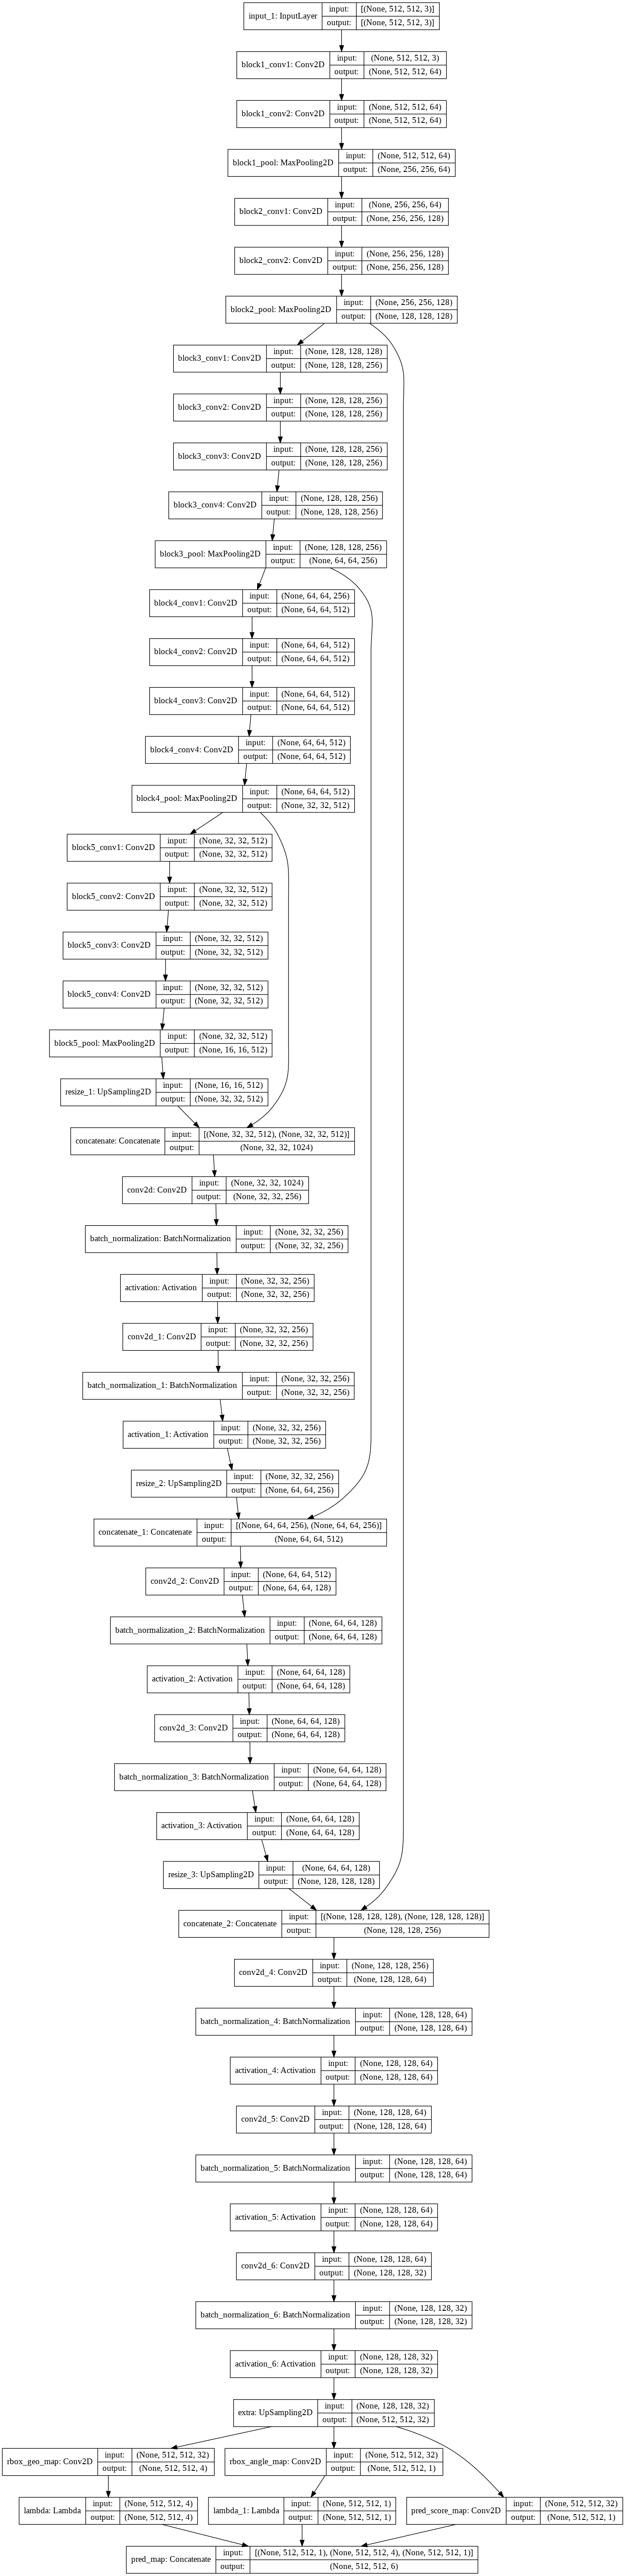

In [24]:
tf.keras.utils.plot_model(vgg19,show_shapes=True)

In [ ]:
vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=total_Loss())
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_vgg19',write_images=True,histogram_freq=1)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.90,patience=2,mode='min')
early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
callbacks=[reduce_lr,early,tensorboard]
vgg19.fit(generator(batch_size=10),steps_per_epoch=100,epochs= 5,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 1605s 16s/step - loss: 8.7123
Epoch 2/5
100/100 [==============================] - 1700s 17s/step - loss: 6.1075
Epoch 3/5
100/100 [==============================] - 1639s 16s/step - loss: 5.5440
Epoch 4/5
100/100 [==============================] - 1652s 17s/step - loss: 4.9330
Epoch 5/5
100/100 [==============================] - 1672s 17s/step - loss: 4.7664


In [ ]:
vgg19.fit(generator(batch_size=10),steps_per_epoch=100,epochs=2,callbacks=callbacks)

Epoch 1/2
100/100 [==============================] - 1628s 16s/step - loss: 4.5001
Epoch 2/2
100/100 [==============================] - 1555s 16s/step - loss: 4.1747


In [ ]:
# Saving the weights
vgg19.save_weights('/content/drive/MyDrive/scene text detection and recognition/weights/vgg19_synthtext.h5')

#### Training on ICDAR 2015 dataset with pretrained weights of Synthtext data

#### Data:https://rrc.cvc.uab.es/?ch=4&com=downloads

In [27]:
def creating_dataframe(dir_path,train_test):
    a =[]
    for i in os.listdir(dir_path):
      if i == train_test or i == train_test+'_gt':
        dir_path1 = dir_path+ i
        dir_path2= pathlib.Path(dir_path1)
        dir_path3=dir_path2.glob('*.*')
        dir_path3 = [str(j) for j in dir_path3]
        a.append(dir_path3)
    data_frame=pd.DataFrame(list(zip(a[1],a[0])),columns=['images', 'ground_truth'])
    data_frame['images']=sorted(data_frame['images'])
    data_frame['ground_truth']=sorted(data_frame['ground_truth'])
    return data_frame

In [26]:
import pathlib
train_data = creating_dataframe("/content/drive/MyDrive/ICDAIR2015/","train")
train_data.head()

,images,ground_truth
0,/content/drive/MyDrive/ICDAIR2015/train/img_1.jpg,/content/drive/MyDrive/ICDAIR2015/train_gt/gt_...
1,/content/drive/MyDrive/ICDAIR2015/train/img_10...,/content/drive/MyDrive/ICDAIR2015/train_gt/gt_...
2,/content/drive/MyDrive/ICDAIR2015/train/img_10...,/content/drive/MyDrive/ICDAIR2015/train_gt/gt_...
3,/content/drive/MyDrive/ICDAIR2015/train/img_10...,/content/drive/MyDrive/ICDAIR2015/train_gt/gt_...
4,/content/drive/MyDrive/ICDAIR2015/train/img_10...,/content/drive/MyDrive/ICDAIR2015/train_gt/gt_...


In [28]:
print(len(os.listdir('/content/drive/MyDrive/ICDAIR2015/train')))

1000


In [29]:
test_data = creating_dataframe("/content/drive/MyDrive/ICDAIR2015/","test")
test_data.head()

,images,ground_truth
0,/content/drive/MyDrive/ICDAIR2015/test/img_1.jpg,/content/drive/MyDrive/ICDAIR2015/test_gt/gt_i...
1,/content/drive/MyDrive/ICDAIR2015/test/img_10.jpg,/content/drive/MyDrive/ICDAIR2015/test_gt/gt_i...
2,/content/drive/MyDrive/ICDAIR2015/test/img_100...,/content/drive/MyDrive/ICDAIR2015/test_gt/gt_i...
3,/content/drive/MyDrive/ICDAIR2015/test/img_101...,/content/drive/MyDrive/ICDAIR2015/test_gt/gt_i...
4,/content/drive/MyDrive/ICDAIR2015/test/img_102...,/content/drive/MyDrive/ICDAIR2015/test_gt/gt_i...


In [30]:
print(len(os.listdir('/content/drive/MyDrive/ICDAIR2015/test')))

500


In [31]:
#vocabulary creation
l=list(train_data['ground_truth'])
CLASSES=[]
for i in tqdm(l):
    file=open(i)
    for line in file:
        line=line.replace('\n','')
        a=line.split(",")[-1]
        if a!='':
            CLASSES.append(a)
NUM_CLASSES=len(list(set(CLASSES))) 

100%|██████████| 1000/1000 [00:48<00:00, 20.69it/s]


In [32]:
NUM_CLASSES

2683

In [38]:
def generator(input_size=512, batch_size=32):
    '''Generator Function used fo training the model'''
    gt_list = train_data['ground_truth'].values
    image_list = train_data['images'].values
    index = np.arange(0, image_list.shape[0])
    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        rboxes = []
        tags = []
        recg_masks = []
        for i in index:
            try:
                if image_list[i]=='Data/ICDAR_15/train/img_141.jpg':
                  continue
                im_fn = image_list[i]
                
                im = cv2.imread(im_fn,cv2.IMREAD_UNCHANGED)
                
                # print im_fn
                h, w, _ = im.shape
               # txt_fn = im_fn
                text_polys, text_tags = load_annoataion(gt_list[i])
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                
                
                #resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

                
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

                

                images.append(im)
                image_fns.append(im_fn)
                score_maps.append(score_map[::, ::, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::, ::, :].astype(np.float32))
                training_masks.append(training_mask[::, ::, np.newaxis].astype(np.float32))
                
                
                
                rboxes.append(rbox)
                tags.append(text_tags)
                recg_masks.append(recg_mask)

                if len(images) == batch_size:
                    yield (np.array(images),np.concatenate([np.array(score_maps), np.array(geo_maps), np.array(training_masks)],axis=3))
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
                    rboxes = []
                    tags = []
                    recg_masks = []
            except Exception as e:
                print(image_list[i])
                import traceback
                traceback.print_exc()
                continue


In [39]:
#LOading the pretrained synthtext weights
vgg19.load_weights('/content/drive/MyDrive/scene text detection and recognition/weights/vgg19_synthtext.h5')
#Compilying the model
vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=total_Loss())
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_vgg19',write_images=True,histogram_freq=1)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.90,patience=2,mode='min')
early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
callbacks=[reduce_lr,early,tensorboard]
vgg19.fit(generator(batch_size=10),steps_per_epoch=100,epochs= 20,callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 709s 7s/step - loss: 1.3554
Epoch 2/20
100/100 [==============================] - 432s 4s/step - loss: 1.0602
Epoch 3/20
100/100 [==============================] - 424s 4s/step - loss: 0.9434
Epoch 4/20
100/100 [==============================] - 428s 4s/step - loss: 0.8924
Epoch 5/20
100/100 [==============================] - 425s 4s/step - loss: 0.8498
Epoch 6/20
100/100 [==============================] - 432s 4s/step - loss: 0.8427
Epoch 7/20
100/100 [==============================] - 423s 4s/step - loss: 0.7796
Epoch 8/20
100/100 [==============================] - 424s 4s/step - loss: 0.7736
Epoch 9/20
100/100 [==============================] - 431s 4s/step - loss: 0.7476
Epoch 10/20
100/100 [==============================] - 425s 4s/step - loss: 0.7233
Epoch 11/20
100/100 [==============================] - 427s 4s/step - loss: 0.7071
Epoch 12/20
100/100 [==============================] - 414s 4s/step - loss: 0.7180
Epoch 13/20
1

In [59]:
# Save the weights
vgg19.save_weights('/content/drive/MyDrive/scene text detection and recognition/weights/vgg19_1_synthtext.h5')

#### Inference pipeline

In [60]:
#https://github.com/argman/EAST/blob/master/eval.py
def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]

In [61]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union

In [62]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g

In [63]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]

In [64]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [70]:
# Inference pipeline function used for generating predicted bounding boxes on image for text detection
def inferencePipeline(img):
  
  start_time=time.time()
  #Text Detection
  img=cv2.resize(img,(512,512))
  ii=vgg19.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]

  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map
  #ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]
  #filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)
  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]
  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)
  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
  
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:

    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
  #Text Recognition (From boxes given by Text Detection+ROI Rotate) 
  if len(rotateParas) > 0:
      
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        pts.append(points)
  #Labeling detected and Recognized Text in Image
    
  for i in range(len(pts)):
      cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=2)
  end_time=time.time()
  print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds") 
  return img   


Time Taken By Pipeline=0.4418013095855713 seconds


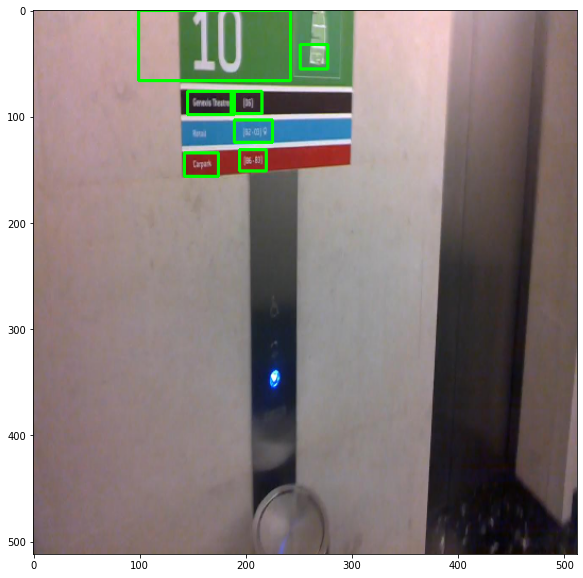

In [72]:
img=cv2.imread('/content/drive/MyDrive/ICDAIR2015/train/img_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im=inferencePipeline(img)
plt.figure(figsize=(10,10))
plt.imshow(im)